In [45]:
using GaussianProcesses
using Random
using LinearAlgebra
using Distributions
using Plots
using Optim
using StatsFuns

using Rasters
using GeoArrays
using CSV
using DataFrames

import StatsBase
import MultivariateStats

using PyCall

Forrás: 
http://krasserm.github.io/2020/11/04/gaussian-processes-classification/

# Bevezető 

A fajelterjedési modellek legtöbbje esetében azzal a problémával szembesülünk, hogy a modellezni kívánt fajről csak a jelenlét adatok állnak a rendelkezésünkre, míg hiány adatok nem (sok esetben nem tudjuk, hogy hol nem él az adott faj). Ezt pszeudo-hiány pontok véletlenszerű létrehozásával szokták ellensúlyozni. 

A mi esetünkben úgy választottunk meg két pettyes gőte alfajt, hogy azok elterjedése térben komplementer legyen. Azaz, ahol az egyik alfajt morfológiai és genentikai bélyegek alapján megtalálták, ott a másik alfaj nem fordult elő. Az erdélyi pettyes gőte (*Lissotriton vulgaris ampelensis*) kimondottan az Erdélyi-medencére jellemző, míg a pettyes gőte alap alfaja (*Lissotriton vulgaris vulgaris*) a Kárpátokon kívülre jellemző. 

Bizonyos élőlénycsoportok esetében területarányosan kevés adat áll rendelkezésünkre, mint például jelen esetben: 
- 411 jelenlét-pont az erdélyi pettyes gőte esetében; és
- 226 a pettyes gőte alap alfajának esetében 


Szeretnénk vizsgálni, hogy: 
1. A pszeudo-hiány pontok helyett használhatók-e a két komplementer elterjedést mutató alfaj jelenlét adatai egy bináris osztályozási probléma célváltozójaként?
2. Gauss-folyamatok által tanulható-e a fajok elterjedése bioklimatikai változók alapján?

A két pettyes gőte alfaj jelenlét pontjait tekintsük a bináris osztályozás célváltozójának. Lássuk el címkékkel a jelenlét adatokat; legyen:
- az erdélyi pettyes gőte címke: 1
- az alap pettyes gőte alfaj címke: 0. 

A célváltozónk tehát két értéket vehet fel $Y \in \{0,1\}$ és *Y* Bernoulli eloszlást követ: 
$$p(Y=1|a) = \sigma(a)$$

$$ p(Y=0|a) = 1 - p(Y = 1|a),$$

ahol $\sigma(a)$ logisztikus szigmoid függvény, amely az $a \in \mathbb{R}$ argumentum logit értékeit alakítja át *0* és *1* közé. Az $a$ argumentumot az $X \in \mathbb{R}^d$ adatpontok határozzák meg, ahol $d$ a hassznált környezeti változók száma. 

## Bioklimatikai változók bemutatása

A környezeti változók közül a leggyakrabban a bioklimatikai változókat használják. A bioklimatikai változók globális lefedettséggel bírnak, legnagyobb felbontásuk kb. 1 $\times$ 1 km (ez helyileg változik a vetületi rendszer korrekciók és átalakítások miatt; https://www.worldclim.org/data/v1.4/worldclim14.html). A WorldClim 1.4. 1960 és 1990 közötti adatok alapján lett létrehozva, míg a WorldClim 2.0 1970-2000 közötti adatokon áll. 

Az letölthető raszteradatok összesen 19 különálló rasztert, azaz változót tartalmaznak: 


1. Éves átlag hőmérséklet (Celsius fok)

2. Éves átlagos napi tartomány: a havi hőmérsékleti tartományok átlaga (havi maximum -- havi minimum); Celsius fokban kifejezve. 

3. Izotermalitás:  Az izotermalitás számszerűsíti, hogy a nappal-éjszaka hőmérsékletek mekkora oszcillációt mutatnak a nyári-téli (éves) ingadozásokhoz képest; százalékban kifejezve.

4. Hőmérséklet Szezonalitás (szórás): Celsius-fok; az eredeti adatot megszorozzuk 100-zal.!!!!! 

5. Legmelegebb hónap maximális hőmérséklete: A maximális havi hőmérséklet egy adott év (idősor) során. Mértékegység: Celsius fok.

6. A leghidegebb hónap minimális hőmérséklete: A minimális havi hőmérséklet egy adott év során. Mértékegység: Celsius fok.

7. Éves hőmérsékleti tartomány: A hőmérséklet változásának mértéke egy adott időszakban. Mértékegység: Celsius fok.
    
8. A legcsapadékosabb negyedév átlaghőmérséklete: Ez a negyedéves index a legcsapadékosabb évszakban uralkodó átlaghőmérsékleteket közelíti meg. Mértékegységek: Celsius fok.
    
9. A legszárazabb negyedév átlaghőmérséklete: Ez a negyedéves mutató a legszárazabb negyedévben uralkodó átlaghőmérsékleteket közelíti meg. Mértékegységek: Celsius fok.

10. A legmelegebb negyedév átlaghőmérséklete: Ez a negyedéves mutató a legmelegebb negyedévben uralkodó átlaghőmérsékleteket közelíti meg. Mértékegységek: Celsius fok.

11. A leghidegebb negyedév átlaghőmérséklete: Ez a negyedéves mutató a leghidegebb negyedévben uralkodó átlaghőmérsékleteket közelíti meg. Mértékegységek: Celsius fok.

12. Éves csapadék: Ez az összes havi csapadék érték összege. Mértékegysége: milliméter. 

    13. Precipitation of Wettest Month: This index identifies the total precipitation that prevails during the wettest month. Units: Millimeters.
    14. Precipitation of Driest Month: This index identifies the total precipitation that prevails during the driest month. Units: Millimeters.
    15. Precipitation Seasonality (CV): This is a measure of the variation in monthly precipitation totals over the course of the year. Units: percent. 
    16. Precipitation of Wettest Quarter: This quarterly index approximates total precipitation that prevails during the wettest quarter. Units: Millimeters.
    17. Precipitation of Driest Quarter: This quarterly index approximates total precipitation that prevails during the driest quarter. Units: Millimeters.
    18. Precipitation of Warmest Quarter: This quarterly index approximates total precipitation that prevails during the warmest quarter. Units: Millimeters.
    19. Precipitation of Coldest Quarter: This quarterly index approximates total precipitation that prevails during the coldest quarter. Units: Millimeters. the mean of the monthly temperature ranges (monthly maximum minus monthly minimum). Degrees celsius.

  



Előzetes kutatásaink alapján elmondhatjuk, hogy a pettyes gőte elterjedési adatok jobban tanulhatók a WorldClim 1.4 használatával, mint a WorldClim 2.0-val. 

# Vizuális adatbemutatás

Beolvassuk a két pettyes gőte alfaj elterjedési adatait .CSV fájlból, míg a bioklimatikai változókat a Quantum GIS (3.16) térinformatikai szoftverben egy többrétegű/többsávos raszterbe fűztük össze és választottuk ki a kutatási területet.

In [10]:
bioclim = RasterStack("bioclim_romania/Bioclim_raster_to_Romania_WGS84.tif")

RasterStack with dimensions: 
  X Projected range(16.8083, stop=28.5167, length=1406) ForwardOrdered Regular Intervals crs: WellKnownText,
  Y Projected range(50.8167, stop=43.45, length=885) ReverseOrdered Regular Intervals crs: WellKnownText,
  Band Categorical 1:19 ForwardOrdered
and 1 layer:
  :layer1 Float32 dims: X, Y, Band (1406×885×19)

with metadata Metadata{Rasters.GDALfile} of Dict{Symbol, Any} with 3 entries:
  :offset   => 0.0
  :scale    => 1.0
  :filepath => "bioclim_romania/Bioclim_raster_to_Romania_WGS84.tif"

In [11]:
ampelensis = Matrix(CSV.read("input_data/ampelensis_data_WGS84.csv", DataFrame))
vulgaris = Matrix(CSV.read("input_data/vulgaris_data_WGS84.csv", DataFrame))

ampelensis = ampelensis[:, 3:4]
vulgaris = vulgaris[:, 3:4];

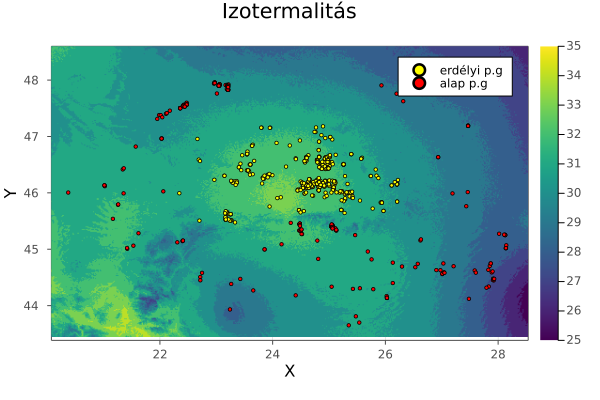

In [13]:
plt = plot(bioclim[:, :, 3], xlim = (20.075, 28.5333), ylim = (43.3833, 48.6), 
    c = :viridis, title = "Izotermalitás")

scatter!(plt, ampelensis[:,1], ampelensis[:, 2], markersize = 2,
    c = :yellow, label = "erdélyi p.g")

scatter!(plt, vulgaris[:,1], vulgaris[:, 2], markersize = 2,
    c = :red, label = "alap p.g")

# Bioklíma-profilok létrehozása főkomponens analízissel

A bioklimatikai változók számossága és a közöttük fennálló multikollinearitás miatt bizonyos módszertani cikkek a változók szelektálását javasolják. Ennek több lehetséges módja van, Yoon és Lee (2021) négy alapvető változószelekciót foglal össze: 

1. A teljes változókészlet: ebben az esetben mind a 19 változót felhasználjuk, nem szelektálunk közülük. 
2. Korreláció alapú szelekció, azaz bizonyos korrelációs érték alatti változókat választunk ki csak. 
3. Variancia-infláció faktor (VIF) alapú változószelekció; illetve,
4. Főkomponens-alapú változószelekció: ebben az esetben felhasználó által kiválasztott főkomponenseket használjuk a modellezés során, mint klíma-profilok. 

Ebben az esetben, mivel két közelrokon pattyes gőte alfajt haszálnuk a modellezés során, az egyik az Erdélyi-medencére jellemző, míg a másik a Kárpát-kanyaron kívülre, megtörténhet, hogy az egyik faj elterjedését meghatározzák bizonyos bioklimatikai változók, míg a másik faj elterjedését meghatározzák másmilyen bioklimatikai változók. 

Amennyiben a leggyakrabban alkalmazott fajelterjedési-modelleket használnánk, külön kellene válasszuk a két alfajt, mindkettő esetében külön-külön generálnánk pszeudo-hiány pontokat, és két külön modell segítségével értékeljük a kapott elterjedéseket. 

Mivel vizsgálatunknak a célja, hogy pszeudo-hiány pontok generálása helyett bináris osztályozást végezzünk a két alfaj elterjedési pontjait felhaszálva, a főkomponens alapú tulajdonságvektor építés célravezetőbb lehet. A két első főkomponenst, mint bioklíma-profilokat felhasználva vizsgáljuk, hogy a két alfaj elterjedése tanulható-e a tulajdonságok alapján. 

## Raszter értékek kiolvasása mintavételi pontokban

A főkomponens elemzéshez szükséges, hogy kiolvassuk a raszterből a 19 bioklimatikai értéket. A kiolvasott adatok mátrix adatstruktúraként jelennek meg. Az egyes bioklíma változókat z-érték alapján standardizáljuk, majd alkalmazzuk rá a *MultivariateStats* könyvtár főkomponens analízisének lépéseit. 

In [5]:
rast_values = Array(bioclim.data.layer1)

# Linearize data
bio_mat = ones((length(rast_values[:, :, 1]), 19))
for i in 1:19
   bio_mat[:, i] = vec(rast_values[:, :, i])
end

In [6]:
bio_mat_standardized = StatsBase.standardize(StatsBase.ZScoreTransform, bio_mat, dims = 1)

1244310×19 Matrix{Float64}:
 -0.313265  -0.618297   0.699662  …  -1.31729    -0.0562792  -1.28858
 -0.313265  -0.618297   0.699662     -1.31729    -0.0562792  -1.28858
 -0.313265  -0.483699   0.699662     -1.28271    -0.036279   -1.2608
 -0.364637  -0.483699   0.699662     -1.28271    -0.036279   -1.2608
 -0.364637  -0.483699   0.699662     -1.28271    -0.0562792  -1.2608
 -0.313265  -0.483699   0.699662  …  -1.28271    -0.0562792  -1.2608
 -0.261892  -0.483699   0.699662     -1.31729    -0.0762793  -1.28858
 -0.261892  -0.483699   0.699662     -1.31729    -0.0962794  -1.28858
 -0.261892  -0.483699   0.699662     -1.31729    -0.11628    -1.28858
 -0.261892  -0.483699   0.699662     -1.31729    -0.11628    -1.28858
 -0.261892  -0.483699   0.699662  …  -1.28271    -0.0962794  -1.2608
 -0.313265  -0.483699   0.699662     -1.28271    -0.0762793  -1.23302
 -0.313265  -0.483699   0.699662     -1.28271    -0.0762793  -1.23302
  ⋮                               ⋱                          
  1.5

In [14]:
M = MultivariateStats.fit(MultivariateStats.PCA, bio_mat_standardized'; pratio=1, maxoutdim=5)

PCA(indim = 19, outdim = 5, principalratio = 0.9602241670118687)

In [15]:
bio_transformed = MultivariateStats.transform(M, bio_mat_standardized')

5×1244310 Matrix{Float64}:
 0.193829  0.188302  0.174455  0.190008  …  -2.66747  -2.6473   -2.66491
 1.14332   1.11642   1.04202   1.04925      -2.90425  -2.93616  -2.86354
 0.654362  0.657021  0.585085  0.585956      6.23738   6.25995   6.21351
 3.45039   3.4811    3.44771   3.45077       1.47054   1.49452   1.45084
 0.898314  0.900329  0.849217  0.847699      1.41009   1.39131   1.43203

In [16]:
PC1 = reshape(reverse(bio_transformed[1,:]), size(bioclim.data.layer1[:, :, 1]))
PC2 = reshape(reverse(bio_transformed[2,:]), size(bioclim.data.layer1[:, :, 1]));

A két első főkomponenst GeoArray-objektummá alakítjuk, megjelenítjük térképen és kimentjük .tif formátumban. A főkomponens elemzéshez szükséges mátrixokká alakítás vagy GeoArray objektumba való alakítása során elveszik a georeferencia. A beépített georeferáló függvény felhasználásakor memóriatelítődést tapasztaltam, így a .tif formátumba kimentett két főkomponenst a Quantum GIS segítségével georeferáltam, majd beolvastam újra. 

In [17]:
ga1 = GeoArray(reverse(PC1, dims = 1))
ga2 = GeoArray(reverse(PC2, dims = 1))

GeoArrays.write!("bioclim_romania/Bioclim_PC1_need_georef.tif", ga1)
GeoArrays.write!("bioclim_romania/Bioclim_PC2_need_georef.tif", ga2)

"bioclim_romania/Bioclim_PC2_need_georef.tif"

Beolvasom újra a georeferált PCA raszter értékeket. 

In [18]:
bioclimPCA = RasterStack("bioclim_romania/rasterPCA_clipped.tif")

RasterStack with dimensions: 
  X Projected range(20.075, stop=28.5333, length=1016) ForwardOrdered Regular Intervals crs: WellKnownText,
  Y Projected range(48.6, stop=43.3833, length=627) ReverseOrdered Regular Intervals crs: WellKnownText,
  Band Categorical 1:2 ForwardOrdered
and 1 layer:
  :layer1 Float32 dims: X, Y, Band (1016×627×2)

with metadata Metadata{Rasters.GDALfile} of Dict{Symbol, Any} with 3 entries:
  :offset   => 0.0
  :scale    => 1.0
  :filepath => "bioclim_romania/rasterPCA_clipped.tif"

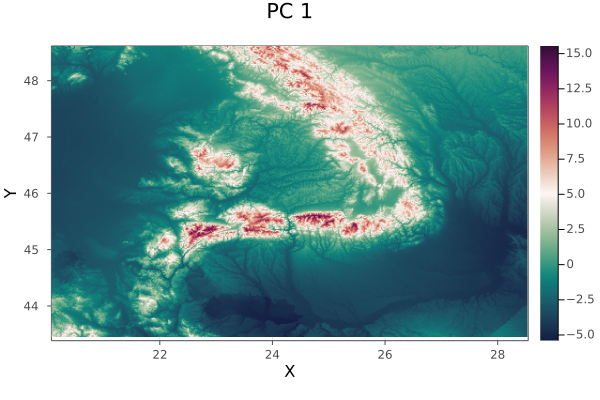

In [23]:
plot(bioclimPCA[:, :, 1], title = "PC 1")

A fajelterjedési modellhez szükség van arra, hogy egyes pontokban tudjuk kivonatolni a raszter értékeket. Ehhez az alábbi függvényt használom fel. A jelenlegi felhasználástól eltérően ha a *state* paramétert "presence"-re állítjuk, akkor automatikusan 1-essel címkézi fel a kinyert értékeket, míg az "absence" értéknél randomizál egy címkét az értékeknek, amely címke jelen beállítások szerint egy valós szám. 

In [21]:
function extractValues(points, raster, state, rand_min = 0, rand_max = 0.1)
    nrow = size(points)[1]
    output = Array(extract(raster, points[1,:])[3])
    
    xlim = [minimum(Array(dims(raster)[1])), maximum(Array(dims(raster)[1]))]
    ylim = [minimum(Array(dims(raster)[2])), maximum(Array(dims(raster)[2]))]
    
    
    if nrow > 1
        for i ∈ 2:nrow
           
            if xlim[1] <= points[i,1] <= xlim[2] && ylim[1] <= points[i,2] <= ylim[2]
                temp = Array(extract(raster, points[i,:])[3]) # a harmadik elem az extract outputból tartalmazza a raszter értékeket
                output = hcat(output, temp)
                
            end
        end
    end
    
    if state == "absence"
       state_values = rand(Uniform(rand_min, rand_max), size(output)[2])    
    elseif state == "presence"
        state_values = ones(size(output)[2])
    end
    
    output = hcat(state_values, transpose(output))
    return output

end

extractValues (generic function with 3 methods)

Első lépésként random mintavételezek a térben 10 000 pontban, ezekre az adatpontokra fogok prediktálni a betanított modellel.

In [26]:
raster_xlim = [minimum(Array(dims(bioclimPCA)[1])), maximum(Array(dims(bioclimPCA)[1]))]
raster_ylim = [minimum(Array(dims(bioclimPCA)[2])), maximum(Array(dims(bioclimPCA)[2]))]

2-element Vector{Float64}:
 43.383333333
 48.599999999666665

In [27]:
function randomSampling(xlim, ylim, n_samples = 10_000)
    x_coords = rand(Uniform(xlim[1], xlim[2]), n_samples)
    y_coords = rand(Uniform(ylim[1], ylim[2]), n_samples)
    return hcat(x_coords, y_coords)
end


Random.seed!(3576)
pseudo_absence = randomSampling(raster_xlim, raster_ylim, 10_000);

Előállítom a tanításhoz szükséges adathalmazt a címkékkel együtt, illetve a predikció alapját képező adathalmazt. 

In [28]:
theta_r_ampelensis = extractValues(ampelensis, bioclimPCA, "presence")
theta_r_vulgaris = extractValues(vulgaris, bioclimPCA, "presence")

X_ampelensis = theta_r_ampelensis[:, 2:3]
X_vulgaris = theta_r_vulgaris[:, 2:3]

X_species = vcat(X_ampelensis, X_vulgaris)


label_ampelensis = theta_r_ampelensis[:, 1]
label_vulgaris = repeat([0], length(theta_r_vulgaris[:, 1]))

Y_species = vcat(label_ampelensis, label_vulgaris);

In [29]:
theta_r_absence = extractValues(pseudo_absence, bioclimPCA, "absence")
X_test_species = theta_r_absence[:, 2:3]

10000×2 Matrix{Float64}:
 -2.09817    -0.593317
 -3.89717     1.51849
 -4.24262     1.41454
 -2.96743     0.610248
 10.0424     -0.088612
  0.332547    1.61037
 -0.87779    -2.02562
 -2.46631    -2.67985
 -2.71735    -1.83469
 -3.73879    -0.571157
 -3.22862     0.969538
  0.675192   -1.8921
  3.63        1.57229
  ⋮          
 -3.3714     -0.658414
 -2.69386    -3.04177
  9.37065    -1.49733
 11.7805     -2.40645
 -0.0930719   1.83248
 -3.38631    -1.40309
 -3.22336     0.151158
  9.03153     0.316482
 -1.04195    -3.53765
 -4.27906     0.126592
 -0.962015    3.55055
 -2.56869    -1.32017

# Gauss-folyamatokkal történő bináris osztályozás bemutatása egy magyarázó változó esetén

A Gauss-folyamatok implementálásához és bemutatásához a dokumentum elején található Python notebookot vettem alapul. 

## Adathalmaz létrehozása

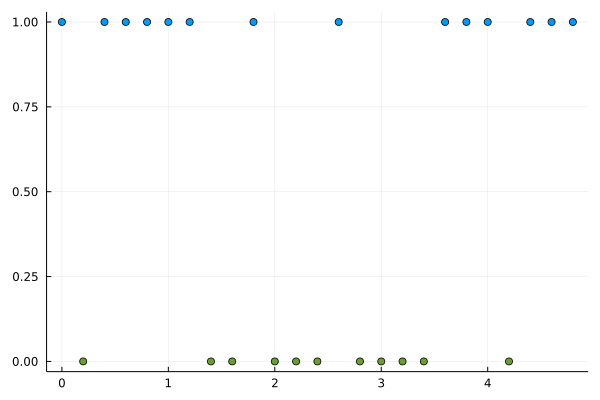

In [33]:
X = [0,0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4,
    2.6, 2.8, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.4, 4.6, 4.8];

Y = [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1];

scatter(X,Y, color = Y, label = false)

A Gauss-folyamat egy véletlenszerű folyamat, ahol minden $X \in \mathbb{R}$ egy $f(x)$ random változó származéka és az $ p(f(x_1)$...$f(x_N))$ a random áltozók kapcsolt normál eloszlása: 

$$ p(f|X) = \mathcal{N}(f|\mu, K),\$$ 

ahol:

$\mu = 0$ és $K = k(X, X)$, ahol $k$ egy paraméteres kernel. 

**A kernel függvény**

Kernel függvénynek egy radiális bázis függvényt választottunk meg. Egy magyarázó változó esetére a következőképpen áll elő a kernel:

$$k(X_1, X_2) = e^{- \frac{1}{2 l^2} D}, $$
ahol $l$ a hossúság skála paraméter *(length scale parameter)* és:
$$ D = X_1 + X_2 - 2 X_1 X_2^{T} $$

In [34]:
function kernel(X1, X2, theta)

    """
    Squared exponential kernel.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        theta: Kernel parameters

    Returns:
        (m x n) matrix
    """
    
    sq_dist = sum(X1.^2, dims = 2) .+ sum(X2.^2, dims = 2)'.- 2 * X1 * X2'
    
    δ = - 0.5/theta[1]^2
    d = exp.(δ*sq_dist)
    
    Σ = theta[2] * d
    
    Σ = Σ + 0.000001*I # It gives Cholesky factorization error without this trick due to floating point precision**
    return(Σ)
end

kernel (generic function with 1 method)

In [36]:
# testing the functions

kernel(X[1:5], X[1:5], (1,1))

5×5 Matrix{Float64}:
 1.0       0.980199  0.923116  0.83527   0.726149
 0.980199  1.0       0.980199  0.923116  0.83527
 0.923116  0.980199  1.0       0.980199  0.923116
 0.83527   0.923116  0.980199  1.0       0.980199
 0.726149  0.83527   0.923116  0.980199  1.0

In [37]:
function compute_W(x)
    r = logistic.(x) .* (1 .- logistic.(x))
    
    return LinearAlgebra.diagm(r)
end

x = Array(1:10)
compute_W(x)

10×10 Matrix{Float64}:
 0.196612  0.0       0.0        0.0        …  0.0          0.0
 0.0       0.104994  0.0        0.0           0.0          0.0
 0.0       0.0       0.0451767  0.0           0.0          0.0
 0.0       0.0       0.0        0.0176627     0.0          0.0
 0.0       0.0       0.0        0.0           0.0          0.0
 0.0       0.0       0.0        0.0        …  0.0          0.0
 0.0       0.0       0.0        0.0           0.0          0.0
 0.0       0.0       0.0        0.0           0.0          0.0
 0.0       0.0       0.0        0.0           0.000123379  0.0
 0.0       0.0       0.0        0.0           0.0          4.53958e-5

In [39]:
function posterior_mode(X, Y, K_a; max_iter = 10, tol = 1e-9)

    a_hat = zeros(size(Y))
    I_mat = LinearAlgebra.I(size(X)[1])

    for i in 1:max_iter
        W = compute_W(a_hat)
        Q_inv = LinearAlgebra.inv(I + W * K_a)
        a_hat_new = K_a * Q_inv * (Y - logistic.(a_hat) + W * a_hat)
        
        a_hat_diff = abs.(a_hat_new .- a_hat)
        a_hat = a_hat_new
        
        if any(a_hat_diff .< tol)
           break
        end
        
    end
    return(a_hat)
end 

posterior_mode (generic function with 1 method)

# Kernel paraméter optimalizáció

A kernel $\theta$ paramétere optimalizálható a marginális log-likelihood által.

$$p(Y|\theta) \approx Y^T \hat{a} - \frac{1}{2} \hat{a}^T K_a^{-1} \hat{a} - 
    \frac{1}{2}log|K_a| - \frac{1}{2}log|W + K_a^{-1}| - \sum_{n=1}^{N} log(1+e^{\hat{a}_n})$$,
    
ahol $N$ a tanító halmaz mérete. 

In [41]:
function negative_loglik_1D(theta; X = X, y = Y)
    K_a = kernel(X,X, theta)
    K_a_inv = LinearAlgebra.inv(K_a) 
    
    a_hat = posterior_mode(X, y, K_a)
    W = compute_W(a_hat)

    ll = - 0.5 * (a_hat' * K_a_inv) * a_hat \
         - 0.5 * logdet(K_a) \ 
         - 0.5 * logdet(W + K_a_inv) \ 
         + (y'  * a_hat) - sum(log.(1 .+ exp.(a_hat)))
    
    return (-ll)
end

negative_loglik_1D([1,1])

14.52474050666531

### Optimalizáció

Előzetes futtatások alapján bizonyos esetekben a Python *scipy* optimalizációs függvényei teljesítenek jobban, míg más esetben a Julia *Optim.jl* optimalizációs függvényei teljesítenek jobban. 

### Optim.jl optimalizáció

In [42]:
inner_optimizer = NelderMead()

f= x -> negative_loglik_1D(x)

initial_x = [1.0, 1.0]
lower = [1e-5, 1e-5]
upper = [30,30]

optim_results = Optim.optimize(f, lower, upper, initial_x, Fminbox(inner_optimizer))

 * Status: success

 * Candidate solution
    Final objective value:     1.413953e+01

 * Found with
    Algorithm:     Fminbox with Nelder-Mead

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.41e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    1
    f(x) calls:    3945
    ∇f(x) calls:   1


In [43]:
optim_results.minimizer

2-element Vector{Float64}:
 1.0
 1.525

### Scipy optimalizálás

In [46]:
sc = pyimport("scipy.optimize")

PyObject <module 'scipy.optimize' from 'C:\\Users\\erosn\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\scipy\\optimize\\__init__.py'>

In [47]:
res = sc[:minimize](fun = negative_loglik_1D, x0 = [2.0, 2.0],  bounds=((1e-3, 20), (1e-3, 20)), method="Nelder-Mead")

Dict{Any, Any} with 8 entries:
  "fun"           => -2.92792
  "nit"           => 32
  "nfev"          => 60
  "status"        => 0
  "success"       => true
  "message"       => "Optimization terminated successfully."
  "x"             => [4.70567, 0.001]
  "final_simplex" => ([4.70567 0.001; 4.70562 0.001; 4.7056 0.001], [-2.92792, …

In [48]:
theta_opt = res["x"]

2-element Vector{Float64}:
 4.705665365599272
 0.001

### Prediktálás

In [54]:
function predict(x, x_train, y_train, theta)
    
    k_a = kernel(x_train, x_train, theta)
    
    # Kernel function returns with dimension mismatch
    
    # Calculate K_s manually
    sq_dist = sum(x.^2, dims = 2) .+ sum(x_train.^2, dims = 2)' .- 2 * x * x_train'
    δ = - 0.5/theta[1]^2
    d = exp.(δ .* sq_dist)
    K_s = theta[2] * d
    K_s = round.(K_s, digits =  6)
    
    a_hat = posterior_mode(x_train, y_train, k_a)
    
    W = compute_W(a_hat)
    W_inv = diagm(transpose(1/diag(W)))
    R_inv = LinearAlgebra.inv(W_inv + k_a)
    
    a_test_mu = K_s * (y_train .- logistic.(a_hat))
    
    K_ss = kernel(x, x, theta) 
    a_test_var = theta[2] .- sum(LinearAlgebra.dot.((K_s * R_inv), K_s), dims = 2)
    kappa = 1 ./ sqrt.( 1 .+ pi * a_test_var ./ 8) 
    
    return(kappa .* a_test_mu)
end

predict (generic function with 1 method)

Létrehozom a predikció alapján képező adathalmazt. 

In [52]:
X_test = range(-2, 7, step = 0.1)

-2.0:0.1:7.0

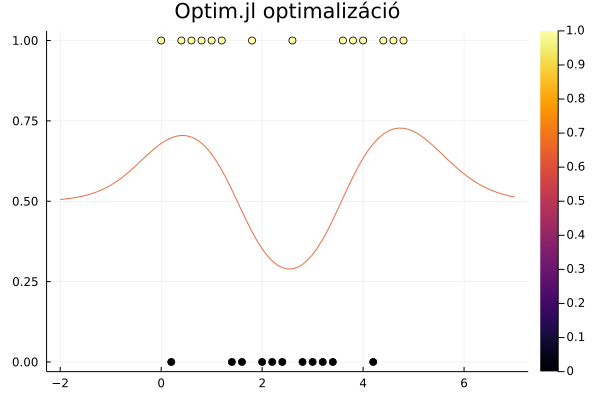

In [59]:
preds = predict(X_test, X, Y, optim_results.minimizer)
pp = logistic.(preds)

plt = scatter(X, Y, label = false, marker_z = Y, title = "Optim.jl optimalizáció")
plot!(plt, X_test, pp, label = false)

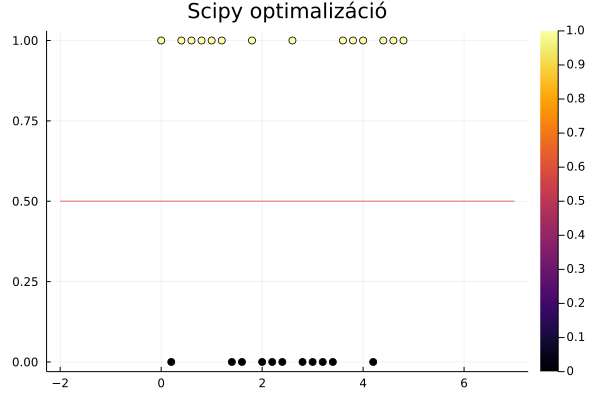

In [60]:
preds = predict(X_test, X, Y, theta_opt)
pp = logistic.(preds)

plt = scatter(X, Y, label = false, marker_z = Y, title = "Scipy optimalizáció")
plot!(plt, X_test, pp, label = false)

# 2D-s eset

In [ ]:
Random.seed!(154)

n_data = 200
dim = 2
cent_1 = [4;4]
rad_sq = 12
X_train = rand(n_data, dim)*10

z = X_train .- cent_1'
class_1 = map(z -> z ? 1 : 0, sum(z .^ 2, dims = 2) .< rad_sq);

Y_occurrence = [class_1[i] for i in 1:length(class_1)];

p = scatter(X_train[:, 1], X_train[:, 2], m=:o, labels=false, color = class_1)
scatter!(p, [cent_1[1]], [cent_1[2]], m=:d, ms = 10, labels = false, aspect_ratio=:equal)

In [ ]:
X1_ = rand(Uniform(-1, 12), 600)
X2_ = rand(Uniform(-1, 12), 600)

X2D = hcat(X1_, X2_);
scatter(X2D[:, 1], X2D[:, 2])

In [ ]:
f = x -> negative_loglik_1D(x; X = X_train, y = Y_occurrence)

initial_x = [1.0, 1.0]
lower = [1e-5, 1e-5]
upper = [30,30]

optim_results = Optim.optimize(f, lower, upper, initial_x, Fminbox(inner_optimizer))

In [ ]:
optim_results.minimizer, optim_results.minimum

In [ ]:
preds = predict(X2D, X_train, Y_occurrence, (0.46,0.675))
pp = logistic.(preds)

In [ ]:
scatter(X2D[:,1], X2D[:,2], marker_z = pp)

## Loss function

In [ ]:
using Flux

In [ ]:
abs(1 - Flux.binarycrossentropy([0.05], [1]))

# Raszter adatok

In [16]:
using Rasters
using GeoArrays
using CSV
using DataFrames

In [3]:
bioclim = RasterStack("bioclim_romania/Bioclim_raster_to_Romania_WGS84.tif")

RasterStack with dimensions: 
  X Projected range(16.8083, stop=28.5167, length=1406) ForwardOrdered Regular Intervals crs: WellKnownText,
  Y Projected range(50.8167, stop=43.45, length=885) ReverseOrdered Regular Intervals crs: WellKnownText,
  Band Categorical 1:19 ForwardOrdered
and 1 layer:
  :layer1 Float32 dims: X, Y, Band (1406×885×19)

with metadata Metadata{Rasters.GDALfile} of Dict{Symbol, Any} with 3 entries:
  :offset   => 0.0
  :scale    => 1.0
  :filepath => "bioclim_romania/Bioclim_raster_to_Romania_WGS84.tif"

In [24]:
ampelensis = Matrix(CSV.read("input_data/ampelensis_data_WGS84.csv", DataFrame))
vulgaris = Matrix(CSV.read("input_data/vulgaris_data_WGS84.csv", DataFrame))

ampelensis = ampelensis[:, 3:4]
vulgaris = vulgaris[:, 3:4];

In [25]:
p = plot(bioclim[:, :, 3], title = "Isothermality", c = :viridis)
scatter!(p, ampelensis[:,1], ampelensis[:,2], markersize = 2, c = :red, label = "Lv. ampelensis")
scatter!(p, vulgaris[:,1], vulgaris[:,2], markersize = 2, c = :blue, label = "Lv. vulgaris")

LoadError: UndefVarError: bioclim not defined

In [26]:
function extractValues(points, raster, state, rand_min = 0, rand_max = 0.1)
    nrow = size(points)[1]
    output = Array(extract(raster, points[1,:])[3])
    
    xlim = [minimum(Array(dims(raster)[1])), maximum(Array(dims(raster)[1]))]
    ylim = [minimum(Array(dims(raster)[2])), maximum(Array(dims(raster)[2]))]
    
    
    if nrow > 1
        for i ∈ 2:nrow
           
            if xlim[1] <= points[i,1] <= xlim[2] && ylim[1] <= points[i,2] <= ylim[2]
                temp = Array(extract(raster, points[i,:])[3]) # a harmadik elem az extract outputból tartalmazza a raszter értékeket
                output = hcat(output, temp)
                
            end
        end
    end
    
    if state == "absence"
       state_values = rand(Uniform(rand_min, rand_max), size(output)[2])    
    elseif state == "presence"
        state_values = ones(size(output)[2])
    end
    
    output = hcat(state_values, transpose(output))
    return output

end

extractValues (generic function with 3 methods)

In [27]:
theta_r_ampelensis = extractValues(ampelensis, bioclimPCA, "presence")
theta_r_vulgaris = extractValues(vulgaris, bioclimPCA, "presence")

220×3 Matrix{Float64}:
 1.0  -4.64105   -0.193426
 1.0  -4.65019   -0.192056
 1.0  -4.88018    0.675587
 1.0  -4.87805    0.671587
 1.0  -4.87693    0.752971
 1.0  -4.87805    0.671587
 1.0  -3.13829   -1.53741
 1.0  -3.10611   -1.48403
 1.0   2.76321    0.746989
 1.0   6.49149    0.0558091
 1.0   4.40276    0.577358
 1.0   4.40276    0.577358
 1.0   4.40276    0.577358
 ⋮               
 1.0  -3.43201   -0.512848
 1.0  -4.69885    0.46361
 1.0  -0.482118   0.758094
 1.0  -2.53185   -1.11724
 1.0  -3.43175   -0.481596
 1.0  -4.86494    0.967848
 1.0  -4.86494    0.967848
 1.0  -3.43201   -0.512848
 1.0  -4.69885    0.46361
 1.0  -4.86494    0.967848
 1.0  -4.87996    0.965986
 1.0  -3.43201   -0.512848

In [28]:
X_ampelensis = theta_r_ampelensis[:, 2:3]
X_vulgaris = theta_r_vulgaris[:, 2:3]

X_species = vcat(X_ampelensis, X_vulgaris)

631×2 Matrix{Float64}:
  3.77419    2.08236
  4.04415    1.98473
  3.78297    2.07894
  3.78297    2.07894
  4.88958    1.69019
  3.78297    2.07894
  3.51934    2.24667
 -1.63833    0.9339
 -1.51046    1.38713
  4.65621    1.71229
  3.67602    2.0836
  0.897167   2.56094
  0.897167   2.56094
  ⋮         
 -3.43201   -0.512848
 -4.69885    0.46361
 -0.482118   0.758094
 -2.53185   -1.11724
 -3.43175   -0.481596
 -4.86494    0.967848
 -4.86494    0.967848
 -3.43201   -0.512848
 -4.69885    0.46361
 -4.86494    0.967848
 -4.87996    0.965986
 -3.43201   -0.512848

In [29]:
label_ampelensis = theta_r_ampelensis[:, 1]
label_vulgaris = repeat([0], length(theta_r_vulgaris[:, 1]))

Y_species = vcat(label_ampelensis, label_vulgaris);

**Test dataset**

In [30]:
raster_xlim = [minimum(Array(dims(bioclim)[1])), maximum(Array(dims(bioclim)[1]))]
raster_ylim = [minimum(Array(dims(bioclim)[2])), maximum(Array(dims(bioclim)[2]))]

LoadError: UndefVarError: bioclim not defined

In [39]:
function randomSampling(xlim, ylim, n_samples = 10_000)
    x_coords = rand(Uniform(xlim[1], xlim[2]), n_samples)
    y_coords = rand(Uniform(ylim[1], ylim[2]), n_samples)
    return hcat(x_coords, y_coords)
end


Random.seed!(3576)
pseudo_absence = randomSampling(raster_xlim, raster_ylim, 10_000);

In [40]:
theta_r_absence = extractValues(pseudo_absence, bioclimPCA, "absence")
X_test_species = theta_r_absence[:, 2:3];

In [ ]:
inner_optimizer = GradientDescent()

f = x -> negative_loglik_1D(x, X = X_species, y = Y_species)

initial_x = [1.0, 4.0]
lower = [1e-5, 1e-5]
upper = [10,10]

optim_results = Optim.optimize(f, lower, upper, initial_x, Fminbox(inner_optimizer))

In [ ]:
optim_results.minimizer, optim_results.minimum

In [ ]:
preds = predict(X_test_species, X_species, Y_species, optim_results.minimizer)
pp = logistic.(preds)

In [ ]:
# p = plot(bioclim[:, :, 3], title = "Isothermality", c = false)
scatter(pseudo_absence[:,1], pseudo_absence[:,2], markersize = 2, marker_z = pp, label = false)

# Bioklíma profil

In [9]:
import MultivariateStats
import StatsBase

In [10]:
rast_values = Array(bioclim.data.layer1)

1406×885×19 Array{Float32, 3}:
[:, :, 1] =
 82.0  82.0  82.0  82.0  81.0  81.0  …  143.0  141.0  121.0  143.0  145.0
 82.0  82.0  82.0  82.0  81.0  81.0     145.0  144.0  130.0  144.0  145.0
 82.0  81.0  81.0  81.0  82.0  81.0     144.0  141.0  135.0  144.0  145.0
 81.0  81.0  81.0  81.0  82.0  81.0     139.0  143.0  140.0  144.0  144.0
 81.0  82.0  82.0  82.0  82.0  82.0     131.0  145.0  143.0  141.0  144.0
 82.0  82.0  82.0  82.0  82.0  83.0  …  124.0  126.0  143.0  144.0  144.0
 83.0  83.0  83.0  82.0  83.0  82.0     125.0  130.0  143.0  144.0  144.0
 83.0  83.0  83.0  82.0  83.0  83.0     127.0  133.0  143.0  143.0  144.0
 83.0  83.0  83.0  82.0  83.0  83.0     127.0  130.0  142.0  144.0  143.0
 83.0  83.0  83.0  83.0  83.0  83.0     127.0  129.0  137.0  143.0  144.0
 83.0  83.0  82.0  83.0  83.0  83.0  …  127.0  128.0  130.0  143.0  143.0
 82.0  82.0  82.0  83.0  83.0  83.0     131.0  129.0  130.0  138.0  143.0
 82.0  82.0  82.0  83.0  83.0  83.0     132.0  127.0  129.0  133.0  1

In [11]:
# Linearize data
rast_values = Array(bioclim.data.layer1)

bio_mat = ones((length(rast_values[:, :, 1]), 19))

for i in 1:19
   bio_mat[:, i] = vec(rast_values[:, :, i])
end

In [12]:
bio_mat_standardized = StatsBase.standardize(StatsBase.ZScoreTransform, bio_mat, dims = 1);

In [15]:
M = MultivariateStats.fit(MultivariateStats.PCA, bio_mat_standardized'; pratio=1, maxoutdim=5)

PCA(indim = 19, outdim = 5, principalratio = 0.9602241670118687)

In [18]:
LinearAlgebra.eigvals(M)

5-element Vector{Float64}:
 9.523334005936398
 5.734408270875444
 1.467360003391004
 1.0176351590908874
 0.5015217339317923

In [19]:
bio_transformed = MultivariateStats.transform(M, bio_mat_standardized')

5×1244310 Matrix{Float64}:
 0.193829  0.188302  0.174455  0.190008  …  -2.66747  -2.6473   -2.66491
 1.14332   1.11642   1.04202   1.04925      -2.90425  -2.93616  -2.86354
 0.654362  0.657021  0.585085  0.585956      6.23738   6.25995   6.21351
 3.45039   3.4811    3.44771   3.45077       1.47054   1.49452   1.45084
 0.898314  0.900329  0.849217  0.847699      1.41009   1.39131   1.43203

In [20]:
PC1 = reshape(reverse(bio_transformed[1,:]), size(bioclim.data.layer1[:, :, 1]))
PC2 = reshape(reverse(bio_transformed[2,:]), size(bioclim.data.layer1[:, :, 1]));

In [21]:
ga1 = GeoArray(reverse(PC1, dims = 1))
ga2 = GeoArray(reverse(PC2, dims = 1))

1406x885x1 Array{Float64, 3} with AffineMap([1.0 0.0; 0.0 1.0], [0.0, 0.0]) and undefined CRS

In [ ]:
# bbox!(ga1, (min_x=raster_xlim[1], min_y=raster_ylim[1], max_x=raster_xlim[2], max_y=raster_ylim[1]))
# epsg!(ga1, 4326)

In [22]:
ga1 = GeoArray(reverse(PC1, dims = 1))
ga2 = GeoArray(reverse(PC2, dims = 1))

GeoArrays.write!("bioclim_romania/Bioclim_PC1_need_georef.tif", ga1)
GeoArrays.write!("bioclim_romania/Bioclim_PC2_need_georef.tif", ga2)

"bioclim_romania/Bioclim_PC1_need_georef.tif"

In [23]:
GeoArrays.write!("bioclim_romania/Bioclim_PC2_need_georef.tif", ga2)

"bioclim_romania/Bioclim_PC2_need_georef.tif"

In [199]:
bioclimPCA = RasterStack("bioclim_romania/rasterPCA_clipped.tif")

RasterStack with dimensions: 
  X Projected range(20.075, stop=28.5333, length=1016) ForwardOrdered Regular Intervals crs: WellKnownText,
  Y Projected range(48.6, stop=43.3833, length=627) ReverseOrdered Regular Intervals crs: WellKnownText,
  Band Categorical 1:2 ForwardOrdered
and 1 layer:
  :layer1 Float32 dims: X, Y, Band (1016×627×2)

with metadata Metadata{Rasters.GDALfile} of Dict{Symbol, Any} with 3 entries:
  :offset   => 0.0
  :scale    => 1.0
  :filepath => "bioclim_romania/rasterPCA_clipped.tif"

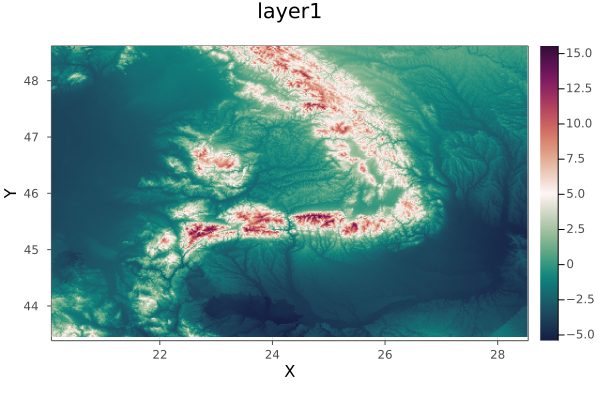

In [200]:
plot(bioclimPCA[:, :, 1])

In [19]:
using PyCall

In [20]:
@pyimport scipy

In [223]:
theta_r_ampelensis = extractValues(ampelensis, bioclimPCA, "presence")
theta_r_vulgaris = extractValues(vulgaris, bioclimPCA, "presence")

X_ampelensis = theta_r_ampelensis[:, 2:3]
X_vulgaris = theta_r_vulgaris[:, 2:3]

X_species = vcat(X_ampelensis, X_vulgaris)

631×2 Matrix{Float64}:
  3.77419    2.08236
  4.04415    1.98473
  3.78297    2.07894
  3.78297    2.07894
  4.88958    1.69019
  3.78297    2.07894
  3.51934    2.24667
 -1.63833    0.9339
 -1.51046    1.38713
  4.65621    1.71229
  3.67602    2.0836
  0.897167   2.56094
  0.897167   2.56094
  ⋮         
 -3.43201   -0.512848
 -4.69885    0.46361
 -0.482118   0.758094
 -2.53185   -1.11724
 -3.43175   -0.481596
 -4.86494    0.967848
 -4.86494    0.967848
 -3.43201   -0.512848
 -4.69885    0.46361
 -4.86494    0.967848
 -4.87996    0.965986
 -3.43201   -0.512848

In [224]:
theta_r_ampelensis = extractValues(ampelensis, bioclimPCA, "presence")
theta_r_vulgaris = extractValues(vulgaris, bioclimPCA, "presence")

X_ampelensis = theta_r_ampelensis[:, 2:3]
X_vulgaris = theta_r_vulgaris[:, 2:3]

X_species = vcat(X_ampelensis, X_vulgaris)


label_ampelensis = theta_r_ampelensis[:, 1]
label_vulgaris = repeat([0], length(theta_r_vulgaris[:, 1]))

Y_species = vcat(label_ampelensis, label_vulgaris)

631-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

2-element Vector{Float64}:
 43.383333333
 48.599999999666665

In [226]:
function randomSampling(xlim, ylim, n_samples = 10_000)
    x_coords = rand(Uniform(xlim[1], xlim[2]), n_samples)
    y_coords = rand(Uniform(ylim[1], ylim[2]), n_samples)
    return hcat(x_coords, y_coords)
end


Random.seed!(3576)
pseudo_absence = randomSampling(raster_xlim, raster_ylim, 10_000);

In [228]:
theta_r_absence = extractValues(pseudo_absence, bioclimPCA, "absence")
X_test_species = theta_r_absence[:, 2:3]

10000×2 Matrix{Float64}:
 -2.09817    -0.593317
 -3.89717     1.51849
 -4.24262     1.41454
 -2.96743     0.610248
 10.0424     -0.088612
  0.332547    1.61037
 -0.87779    -2.02562
 -2.46631    -2.67985
 -2.71735    -1.83469
 -3.73879    -0.571157
 -3.22862     0.969538
  0.675192   -1.8921
  3.63        1.57229
  ⋮          
 -3.3714     -0.658414
 -2.69386    -3.04177
  9.37065    -1.49733
 11.7805     -2.40645
 -0.0930719   1.83248
 -3.38631    -1.40309
 -3.22336     0.151158
  9.03153     0.316482
 -1.04195    -3.53765
 -4.27906     0.126592
 -0.962015    3.55055
 -2.56869    -1.32017

In [245]:
function kernel_new(X1, X2, l_vect, sigma)
    
    """
    Works only with matrices!
    """
    
    N, M = size(X1)
    
    Δ = Array{Float64}(undef,N,N,M)
        
    for i in 1:M
        
        X1_temp = X1[:, i]
        X2_temp = X2[:, i]
        
        sq_dist = sum(X1_temp.^2, dims = 2) .+ sum(X2_temp.^2, dims = 2)'.- 2 * X1_temp * X2_temp'
        Δ[:,:,i] = sq_dist/l_vect[i]^2
    end
    
    Δ = reshape(sum(Δ, dims = 3), (N,N))
    
    k_SE = sigma* exp.(-0.5 * Δ)
    return(k_SE + 1e-5 * I)
end

kernel_new (generic function with 1 method)

In [292]:
function kernel_new_2(X1, X2, l_vect, sigma)
    
    """
    Works only with matrices!
    """
    
    N1, M = size(X1)
    N2, _ = size(X2)
    
    Δ = Array{Float64}(undef,N1,N2,M)
        
    for i in 1:M
        
        X1_temp = X1[:, i]
        X2_temp = X2[:, i]
        
        sq_dist = sum(X1_temp.^2, dims = 2) .+ sum(X2_temp.^2, dims = 2)'.- 2 * X1_temp * X2_temp'
        Δ[:,:,i] = sq_dist/l_vect[i]^2
    end
    
    Δ = reshape(sum(Δ, dims = 3), (N1,N2))
    k_SE = sigma* exp.(-0.5 * Δ)
    k_SE = round.(k_SE, digits =  8)
    return(k_SE)
end

kernel_new_2 (generic function with 1 method)

In [252]:
function negative_ll(theta; X = X_species, y = Y_species)
    K_a = kernel_new(X,X, theta[1:2], theta[3])
    
    K_a_inv = LinearAlgebra.inv(K_a) 
    
    a_hat = posterior_mode2(X, y, K_a)
    W = compute_W(a_hat)

    ll = - 0.5 * (a_hat' * K_a_inv) * a_hat \
         - 0.5 * logdet(K_a) \ 
         - 0.5 * logdet(W + K_a_inv) \ 
         + (y'  * a_hat) - sum(log.(1 .+ exp.(a_hat)))
    
    return (-ll)
end

negative_ll([1,1,1])

1316.2593937031095

In [230]:
sc = pyimport("scipy.optimize")

PyObject <module 'scipy.optimize' from 'C:\\Users\\erosn\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\scipy\\optimize\\__init__.py'>

In [287]:
res = sc[:minimize](fun = negative_ll, x0 = [1.0, 1.0, 1.0],  bounds=((1e-3, NaN), (1e-3, NaN), (1e-3, NaN)), method="L-BFGS-B")

Dict{Any, Any} with 10 entries:
  "hess_inv" => PyObject <3x3 LbfgsInvHessProduct with dtype=float64>
  "fun"      => 434.829
  "nfev"     => 216
  "nit"      => 26
  "status"   => 0
  "message"  => "CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH"
  "x"        => [0.0171367, 47.4881, 0.001]
  "jac"      => [0.186054, 0.0, 355.087]
  "success"  => true
  "njev"     => 54

In [289]:
theta = res["x"]

3-element Vector{Float64}:
  0.017136660759342965
 47.488148522142
  0.001

In [ ]:
# inner_optimizer = LBFGS()

# f = x -> negative_loglik_1D(x; X = X_species, y = Y_species)

# initial_x = [1.0, 2.0]
# lower = [1e-5, 1]
# upper = [40,30]

# optim_results = Optim.optimize(f, lower, upper, initial_x, Fminbox(inner_optimizer))

In [ ]:
optim_results.minimizer, optim_results.minimum

In [302]:
function predict_new(x, x_train, y_train, theta)
    
    k_a =  kernel_new(x_train,x_train, theta[1:2], theta[3])
    
    
    a_hat = posterior_mode2(x_train, y_train, k_a)
    
    W = compute_W(a_hat)
    W_inv = diagm(transpose(1/diag(W)))
    R_inv = LinearAlgebra.inv(W_inv + k_a)
    
    
    K_s = kernel_new_2(x, x_train, theta[1:2], theta[3])
    
    a_test_mu = K_s * (y_train .- logistic.(a_hat))
    
    K_ss = kernel_new(x, x, theta[1:2], theta[3]) 
    a_test_var = theta[3] .- sum(LinearAlgebra.dot.((K_s * R_inv), K_s), dims = 2)
    kappa = 1 ./ sqrt.( 1 .+ pi * a_test_var ./ 8) 
    
    return(kappa .* a_test_mu)
end

predict_new (generic function with 1 method)

In [318]:
preds = predict_new(X_test_species, X_species, Y_species, (30, 30, 1))

10000×1 Matrix{Float64}:
  0.026337378107393512
  0.11296909969735366
  0.03471535779487008
  0.10280184201058983
  1.9921033724612498
  0.8478522659473429
 -0.03411585116316502
 -0.4227393906472371
 -0.3092032446474511
 -0.24804219983857018
  0.1251320403583985
  0.2511076002605236
  1.3762902807874313
  ⋮
 -0.20192873100915582
 -0.527322321560332
  1.6537912521015472
  1.796117723597793
  0.8178593340234207
 -0.3424211626182279
 -0.026278078845381844
  1.9335337191632551
 -0.3411529805481011
 -0.21033235834556185
  0.988089601410876
 -0.18871971496912188

In [319]:
pp = logistic.(preds);

In [233]:
# preds = predict(X_test_species, X_species, Y_species, theta)
# pp = logistic.(preds)

10000×1 Matrix{Float64}:
 0.48438647288682707
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 ⋮
 0.5
 0.5
 0.5
 0.5
 0.5
 0.4999995934760177
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5

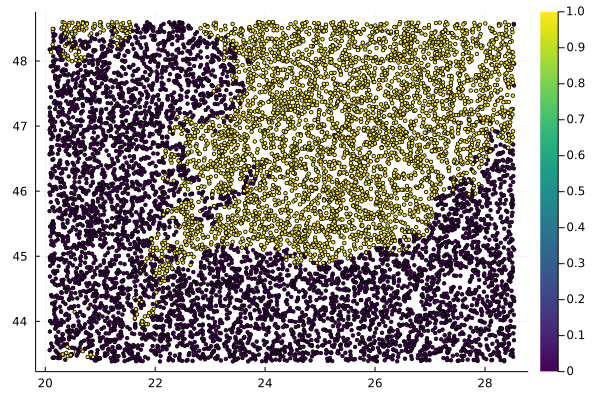

In [326]:
threshold = 0.6
scatter(pseudo_absence[:,1], pseudo_absence[:,2], markersize = 2, marker_z = [pp[i] > threshold ? 1 : 0 for i in 1:length(pp)], label = false, c = :viridis)